In [62]:
import sys
import time
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
pd.options.display.float_format = '{:,.4f}'.format
sys.path.append("c:\python38\lib\site-packages")
#sys.setrecursionlimit(1500)
sns.set(style="whitegrid")
THEME = "darkslategray"

In [3]:
data_file = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
#create headers for the data
headers = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(data_file, sep="\s*,\s*", names = headers, engine='python')

def train_validate_test_split(df, train_percent=.6, validate_percent=.3):
    """
    This function split the data into 3 parts using the split ratios given (0.6:0.3:0.1)
    1. First shuffle the data to ensure that the data split is random
    2. calculate the size of each data
    """
    df_shuffled = df.sample(frac=1)

    n = len(df.index)

    train_end = int(train_percent * n)

    validate_end = int(validate_percent * n) + train_end

    train = df_shuffled.iloc[df_shuffled.index[:train_end]]

    validate = df_shuffled.iloc[df_shuffled.index[train_end:validate_end]]

    test = df_shuffled.iloc[df_shuffled.index[validate_end:]]

    train = train.reset_index(drop=True)
    validate = validate.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, validate, test

#train_set, validate_set, test_set = train_validate_test_split(df, train_percent=.6, validate_percent=.3)


In [54]:
class Node:
    """
    variables used to initialize new nodes
    """
    def __init__(self, label):
        self.attribute = None
        self.attribute_values = []
        self.label = label
        self.children = {}

        # References to the parent node
        self.parent_attribute = None
        self.parent_attribute_value = None

        # Used for pruned trees
        self.pruned = False  
        self.instances_labeled = []

eps = np.finfo(float).eps
from collections import Counter

def entropy(target_data):#(data, target_var = "class"):
    """
    1. determine the unique values in the class/target attribute
        (4 for the dataset in this project: unacc, acc, vgood, good) - unique_value
    2. count total class instances (total_class_count)
    2. Count the total instances of each unique class value (unique_value_count)
    3. calculate probability of occurence of class value (unique_value_count/total_class_count) -prob
    4. calculate the target entroy = sum(prob*log2(prob))
    @return entropy
    """
    values, counts = np.unique(target_data, return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(values))])

    return entropy

def calc_attribute_entropy(data,attribute, target_var = "class"):
    #get unique values and the count of each unique values associated with the attribute
    uniq_values, uniq_val_counts= np.unique(data[attribute],return_counts=True)

    attribute_entropy = 0

    if (uniq_val_counts == 0).any(): #ensure no math error
        return attribute_entropy

    #attribute entropy is sum of entropy for attribute unique values
    else:
        attribute_entropy = np.sum([(uniq_val_counts[i]/np.sum(uniq_val_counts))*

                                entropy(data.where(data[attribute]==uniq_values[i]).dropna()[target_var])

                                for i in range(len(uniq_values))])
    return attribute_entropy

def max_info_gain(data, target_var = "class"):
    """
    Calculate the information gain for each attribute.
    Attribute with the most information has the least entropy and the highest gain
    1. calculate total entropy for the target as total_entropy
    2. calculate attribute entropy as attribute_entropy
    3. gain = total_entropy - attribute_entropy
    @return attribute with max gain
    """
    info_gain = []
    for attribute in data.columns:
        if attribute == target_var: #no need to calculate gain for target variable
            continue

        total_entropy     = entropy(data[target_var])

        attribute_entropy = calc_attribute_entropy(data,attribute, target_var)

        gain = total_entropy - attribute_entropy
        info_gain.append(gain)

    #get attribute with max information gain
    max_ig_attribute = data.columns[np.argmax(info_gain)]

    return  max_ig_attribute

#the list sometimes appear as a series, covert the data to tuples
def converter(x):
    results = []
    for i in x:
        if isinstance(i, pd.Series):
            results.append(tuple(i.values))
        else:
            results.append(i)
    return results

def mode_class(classes):
    """
    get the most frequent class
    """
    targets = []
    for target in classes:
        targets.append(target)
    return Counter(targets).most_common(1)[0][0]

def id3_decison_tree(data, originaldata, features, target_var="class",parent_node_class = None):
    sub = {}
    freguent_target  = np.unique(originaldata[target_var])[np.argmax(np.unique(originaldata[target_var],return_counts=True)[1])]

    if len(np.unique(data[target_var])) <= 1 or len(data[target_var]) == 1:
        tree = Node(np.unique(data[target_var])[0])
        return tree

    #If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data)==0:
        return Node(freguent_target)

    elif len(features) ==0:
        return Node(parent_node_class)

    else:
        parent_node_class = np.unique(data[target_var])[np.argmax(np.unique(data[target_var],return_counts=True)[1])]

        best_feature = max_info_gain(data,target_var)

        tree = Node(parent_node_class)

        tree.attribute = best_feature

        tree.attribute_values = list(np.unique(data[best_feature]))

        for value in np.unique(data[best_feature]):

            sub_data = data[data[best_feature] == value].dropna().reset_index(drop=True)

            subtree = id3_decison_tree(sub_data, sub_data, features, target_var,parent_node_class)

            subtree.instances_labeled = sub_data

            # Keep track of the state of the subtree's parent (i.e. tree)
            subtree.parent_attribute = best_feature # parent node
            subtree.parent_attribute_value = value # branch name

            # Assign the subtree to the appropriate branch
            tree.children[value] = subtree

        return tree

def prune_predict(tree, test_instance):
    '''
    Parameters:
        node: A trained tree node
        test_instance: A single test instance
    Returns:
        Class value (e.g. "Play")
    '''
    # If this is a leaf node (i.e. has no children)
    if len(tree.children) == 0:
        return tree.label

    else:
        # Extract the attribute name (e.g. "Outlook") from the node.
        attribute_value = test_instance[tree.attribute]

        # Follow the branch for this attribute value assuming we have unpruned tree.
        if attribute_value in tree.children and tree.children[attribute_value].pruned == False:
            return prune_predict(tree.children[attribute_value], test_instance)

        # Otherwise, return the most common class
        # return the mode label of examples with other attribute values for the current attribute
        else:
            instances = []
            for attr_value in tree.attribute_values:
                instances.append(tree.children[attr_value].instances_labeled)

            targets = []
            for instance in instances:
                targets.append(instance['class'])
            tuples = converter(targets)
            most_frequent = mode_class(tuples)

            return most_frequent


def tree_accuracy(tree, test_instances):
    """
    Parameters:
        trained_tree: A tree that has already been trained
        test_instances: A set of test instances
    Returns:
        Classification accuracy (# of correct predictions/# of predictions)
    """
    correct_predictions = 0
    for test_instance in test_instances:
        if prune_predict(tree, test_instance) == test_instance['class']:
            correct_predictions += 1

    return (correct_predictions / len(test_instances))

def tree_error(tree, test_set):
    error = 1-tree_accuracy(tree, test_set)
    
    return error

TREE = None
def prune(node, val_instances, threshold):
    """
    Prune the tree recursively, starting from the leaves
    Parameters:
        node: A tree that has already been trained
        val_instances: The validation set
    """
    global TREE
    TREE = node
    def prune_node(node, val_instances, threshold):
        
        # If this is a leaf node
        if len(node.children) == 0:
            error_before_pr = tree_error(TREE, val_instances)
            node.pruned = True

            # If no improvement in accuracy, no pruning
            if error_before_pr+threshold <= tree_error(TREE, val_instances):
                node.pruned = False
            return
        for value, child_node in node.children.items():
            prune_node(child_node, val_instances, threshold)

        # Prune when we reach the end of the recursion
        error_before_pr = tree_error(TREE, val_instances)
        node.pruned = True
        
        if error_before_pr+threshold <= tree_error(TREE, val_instances):
            node.pruned = False
        
    prune_node(TREE, val_instances, threshold)

### Load the data set

In [55]:
train_set = pd.read_csv("train_set.csv")
validate_set = pd.read_csv("validate_set.csv")
test_set = pd.read_csv("test_set.csv")

### Entropy of the attributes

In [56]:
entropy(train_set["class"])

1.2115628264620815

In [86]:
attr = []
entrop = []
for col in train_set.columns:
    attr.append(col)
    if col == "class":
        entrop.append(entropy(train_set[col]))
    else:
        entrop.append(calc_attribute_entropy(train_set,col, "class"))

resutls = pd.DataFrame([attr, entrop])
df_entropy = resutls.T
df_entropy = df_entropy.rename(columns={0:"attribute", 1:"entropy"})
df_entropy.sort_values(by = "entropy", inplace=True)

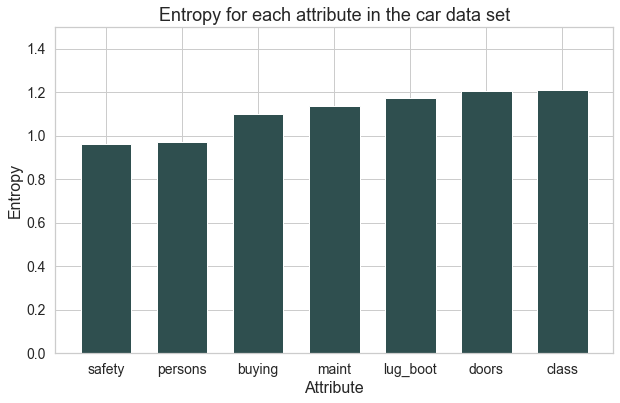

In [95]:
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)
width = 1/1.5
axes.set_title( "Entropy for each attribute in the car data set", fontsize = 18)
axes.bar(df_entropy.attribute, df_entropy.entropy, width, color=THEME, align="center")
axes.yaxis.grid( b=True, which="major")
axes.set_ylim((0, 1.5))
axes.set_xlabel( "Attribute", fontsize = 16)
axes.set_ylabel( "Entropy", fontsize = 16)
axes.tick_params(axis='both', which='major', labelsize=14)

plt.show()

### Information gain of attributes

In [65]:
def max_info_gain(data, target_var = "class"):
    info_gain = []
    attr_list = []
    for attribute in data.columns:
        if attribute == target_var: #no need to calculate gain for target variable
            continue

        total_entropy     = entropy(data[target_var])

        attribute_entropy = calc_attribute_entropy(data,attribute, target_var)

        gain = total_entropy - attribute_entropy
        info_gain.append(gain)
        attr_list.append(attribute)
        
    resutls = pd.DataFrame([attr_list, info_gain])
    df_lg = resutls.T
    df_lg = df_lg.rename(columns={0:"attribute", 1:"info_gain"})

    return  df_lg

df_ig = max_info_gain(train_set, target_var = "class")
df_ig.sort_values(by = "info_gain", inplace=True)

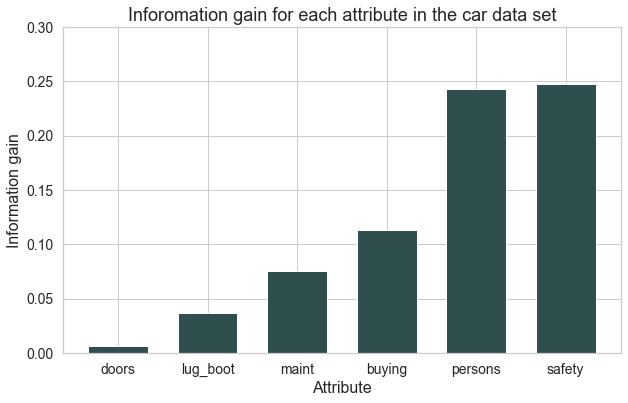

In [96]:
figure = plt.figure(figsize=(10, 6)) 

axes = figure.add_subplot(1, 1, 1)
width = 1/1.5
axes.set_title( "Inforomation gain for each attribute in the car data set", fontsize = 18)
axes.bar(df_ig.attribute, df_ig.info_gain, width, color=THEME, align="center")
axes.yaxis.grid( b=True, which="major")
axes.set_ylim((0, 0.3))
axes.set_xlabel( "Attribute", fontsize = 16)
axes.set_ylabel( "Information gain", fontsize = 16)
axes.tick_params(axis='both', which='major', labelsize=14)
plt.show()

### Threshold tuning

The number of nodes that can be removed from the tree depends on the level of impurities in the attributes (nodes) and the level of acceptable error of prediction. If there are a lot of impure attributes in the data set, significant amount of pruning can be acheived without compromising on decision tree model prediction errors. On the other hand, if impurities of the attributes are comparably the same, then any sigificant level of pruning will result in a model with significant prediction errors. Therefore, it is worth determining the level torlerable errors desired by the model before pruning. The accpetable difference between unpruned model prediction error and the pruned model prediction error is the parameter the modeler needs to detremine beforehand. In some cases, model performance could be so poor that pruning may not be reommended. KNowning the full unpruned model prediction error, a decision can be made as to whether pruning is needed. This study measures the variation of pruning error threshold with model prediction accuracy and prediction error for the data set.

In [33]:
def pruning_error_threshold(train_set, test_set, validate_set):
    """
    The amount
    """
    threshold = 0
    threshold_list = []
    un_prune_errors = []
    unprune_accuracy = []
    prune_errors = []
    prune_accuracy = []
    
    tets_data_dict = test_set.iloc[:,:].to_dict(orient = "records")
    validation = validate_set.iloc[:,:].to_dict(orient = "records")
    
    while threshold < 0.1: 
        dtree = id3_decison_tree(train_set, train_set, train_set.columns[:-1], "class")
        
        unprune_accuracy.append(tree_accuracy(dtree, tets_data_dict))
        un_prune_errors.append(tree_error(dtree, tets_data_dict))
           
        """ below this is the pruning aspect"""
        prune(dtree, validation, threshold)
        prune_accuracy.append(tree_accuracy(dtree, tets_data_dict))
        prune_errors.append(tree_error(dtree, tets_data_dict))
        threshold_list.append(threshold)
        threshold = threshold +  0.001

    #Put the results into a dataframe and label the data accordingly.    
    resutls = pd.DataFrame([threshold_list, un_prune_errors, unprune_accuracy, prune_errors, prune_accuracy])
    df_lg = resutls.T
    df_lg = df_lg.rename(columns={0:"threshold", 1:"unpruned_error", 2:"unpruned_accuracy", 3:"pruned_error", 4:"pruned_accuracy"})
    
    return df_lg

In [34]:
df_thold = pruning_error_threshold(train_set, test_set, validate_set)

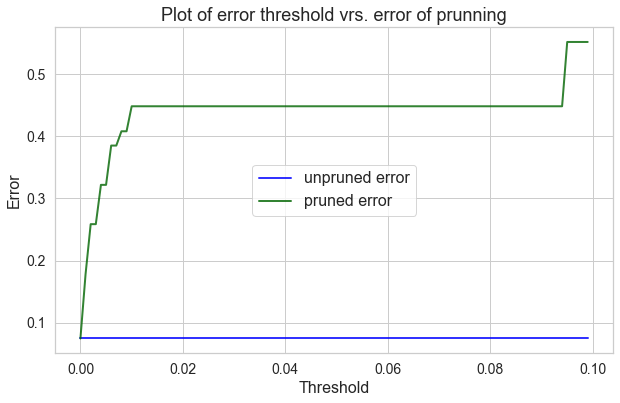

In [105]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)

axes.plot( df_thold.threshold, df_thold.unpruned_error, color="blue", alpha=0.8, label = "unpruned error", lw=2)    
axes.plot( df_thold.threshold, df_thold.pruned_error, color="darkgreen", alpha=0.8, label = "pruned error", lw=2)    
axes.set_title(r"Plot of error threshold vrs. error of prunning", fontsize = 18)
axes.set_xlabel("Threshold", fontsize = 16)
axes.set_ylabel("Error", fontsize = 16)
axes.legend(loc = "center", fontsize = 16)
axes.yaxis.grid( b=True, which="major")
axes.tick_params(axis='both', which='major', labelsize=14)


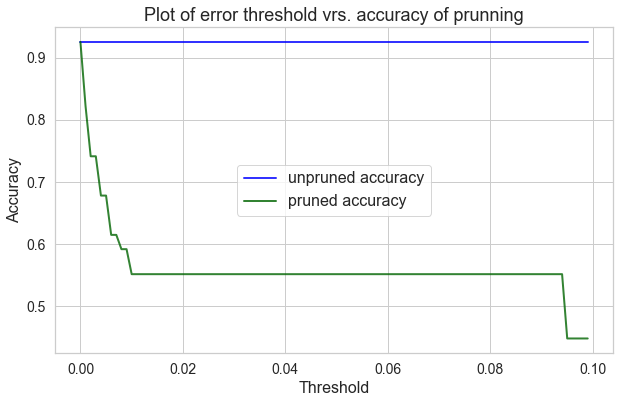

In [104]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot( df_thold.threshold, df_thold.unpruned_accuracy, color="blue", alpha=0.8, label = "unpruned accuracy", lw=2)    
axes.plot( df_thold.threshold, df_thold.pruned_accuracy, color="darkgreen", alpha=0.8, label = "pruned accuracy", lw=2)   
axes.set_title(r"Plot of error threshold vrs. accuracy of prunning", fontsize = 18)
axes.set_xlabel("Threshold", fontsize = 16)
axes.set_ylabel("Accuracy", fontsize = 16)
axes.legend(loc = "center", fontsize = 16)
axes.yaxis.grid( b=True, which="major")
axes.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

It can be seen that the prediction error of a pruned tree is dependent on the level of error threshold that can be tolerated for the model use. The model error is lowest for the unpruned tree but increases as the error threshold. As the error threshold increases, the prune model prediction error also increases. This suggests the nodes removed in the prunning have appreciable information for the model performance. There exist an "equilibrium" threshold range (0.01 to 0.095) within which threshold changes does not affect pruned model errors, an indication that the nodes removed at those levels in the pruning process add little information to performance of the model. Above this "equilibrim" threshold range, further node removal cause significant increase in the prune tree prediction error. Thus, the decision on how much pruning can be done is dependent on the level of the decision tree model fidelity required.

In [51]:
decision_tree = id3_decison_tree(train_set, train_set, train_set.columns[:-1], "class")

tets_data_dict = test_set.iloc[:,:].to_dict(orient = "records")

print("object decision tree")
print("unpruned tree size = ", count_nodes(decision_tree))
print("unprune model test accuracy ", tree_accuracy(decision_tree, tets_data_dict)) 
print("unprune model test error ", tree_error(decision_tree, tets_data_dict)) 

print("pruned tree section")
validation = validate_set.iloc[:,:].to_dict(orient = "records")
prune(decision_tree, validation, 0.01)
print("pruned tree size = ",count_nodes(decision_tree))
print("prune model test accuracy ", tree_accuracy(decision_tree, tets_data_dict))
print("prune model test  error", tree_error(decision_tree, tets_data_dict))

object decision tree
unpruned tree size =  3
unprune model test accuracy  0.9252873563218391
unprune model test error  0.07471264367816088
pruned tree section
pruned tree size =  3
prune model test accuracy  0.5517241379310345
prune model test  error 0.4482758620689655


### Cross- validation

Perform three rounds of 10-fold cross validation, estimating unprune error and prune error. We can then use the results for the test data to calculate 95% Bootstrap estimates of the credible intervals for each.

In [12]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(data, validation_data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    validation = validation_data.iloc[:,:].to_dict(orient = "records")
    
    unprune_accuracy = []
    un_prune_errors = []
    prune_accuracy = []
    prune_errors = []
    for _ in range(repetitions):
        np.random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold].iloc[:,:].to_dict(orient = "records")
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            
            #train the decision tree
            decision_tree = id3_decison_tree(train_data, train_data, train_data.columns[:-1], "class")
            
            """ This section is the unpruned tree performance metrics"""
            unprune_accuracy.append(tree_accuracy(decision_tree, test_data))
            un_prune_errors.append(tree_error(decision_tree, test_data))

            """ below this is the pruning aspect"""
            prune(decision_tree, validation, 0.02)
            prune_accuracy.append(tree_accuracy(decision_tree, test_data))
            prune_errors.append(tree_error(decision_tree, test_data))

    #Put the results into a dataframe and label the data accordingly.    
    resutls = pd.DataFrame([un_prune_errors, unprune_accuracy, prune_errors, prune_accuracy])
    df_lg = resutls.T
    df_lg = df_lg.rename(columns={0:"unpruned_error", 1:"unpruned_accuracy", 2:"pruned_error", 3:"pruned_accuracy"})
    
    return df_lg

In [13]:
cross_val = cross_validation(train_set, validate_set, fold_count=10, repetitions=3)

### Bootstrap sampling

In [17]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [120]:
bootstrap = {}
bootstrap["unpruned_error"] = np.array([np.mean(s) for s in [resample(cross_val.unpruned_error) for i in range( 0, 1000)]])
bootstrap["pruned_error"] = np.array([np.mean(r) for r in [resample(cross_val.pruned_error) for i in range( 0, 1000)]])

bootstrap["unpruned_accuracy"] = np.array([np.mean(s) for s in [resample(cross_val.unpruned_accuracy) for i in range( 0, 1000)]])
bootstrap["pruned_accuracy"] = np.array([np.mean(r) for r in [resample(cross_val.pruned_accuracy) for i in range( 0, 1000)]])

In [126]:
print(r"95% CI for unpruned_error:", stats.mstats.mquantiles(bootstrap["unpruned_error"], [0.025, 0.975]))
print(r"95% CI for pruned_error:", stats.mstats.mquantiles(bootstrap["pruned_error"], [0.025, 0.975]))

95% CI for unpruned_error: [0.0080452  0.01350199]
95% CI for pruned_error: [0.42819173 0.45424049]


In [122]:
print(r"95% CI for unpruned accuracy:", stats.mstats.mquantiles(bootstrap["unpruned_accuracy"], [0.025, 0.975]))
print(r"95% CI for pruned accuracy:", stats.mstats.mquantiles(bootstrap["pruned_accuracy"], [0.025, 0.975]))

95% CI for unpruned accuracy: [0.98617438 0.99196103]
95% CI for pruned accuracy: [0.54582092 0.57167837]


The pruned model has tighter 95% BCI than the unpruned model. Therefore, the pruned model is more generalized and can easily predict unsee data, abeilt at higher error rate.

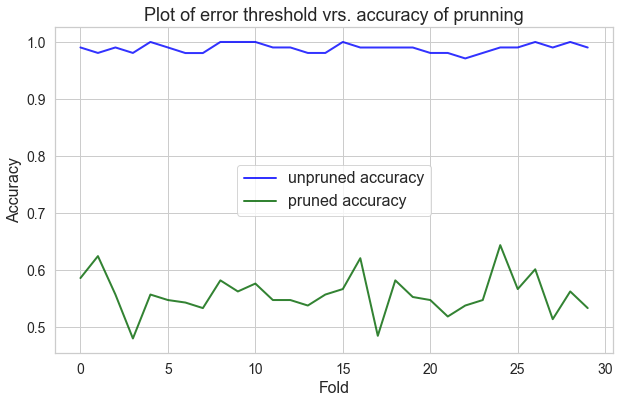

In [125]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(cross_val.index, cross_val.unpruned_accuracy, color="blue", alpha=0.8, label = "unpruned accuracy", lw=2)    
axes.plot(cross_val.index, cross_val.pruned_accuracy, color="darkgreen", alpha=0.8, label = "pruned accuracy", lw=2)   
axes.set_title(r"Plot of error threshold vrs. accuracy of prunning", fontsize = 18)
axes.set_xlabel("Fold", fontsize = 16)
axes.set_ylabel("Accuracy", fontsize = 16)
axes.legend(loc = "center", fontsize = 16)
axes.yaxis.grid( b=True, which="major")
axes.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

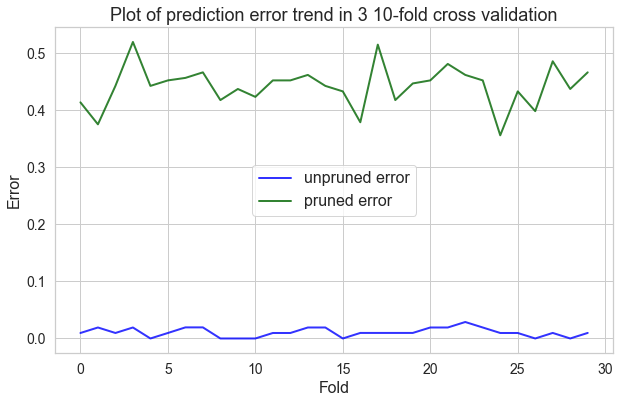

In [124]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)

axes.plot(cross_val.index, cross_val.unpruned_error, color="blue", alpha=0.8, label = "unpruned error", lw=2)    
axes.plot(cross_val.index, cross_val.pruned_error, color="darkgreen", alpha=0.8, label = "pruned error", lw=2)    
axes.set_title(r"Plot of prediction error trend in 3 10-fold cross validation", fontsize = 18)
axes.set_xlabel("Fold", fontsize = 16)
axes.set_ylabel("Error", fontsize = 16)
axes.legend(loc = "center", fontsize = 16)
axes.yaxis.grid( b=True, which="major")
axes.tick_params(axis='both', which='major', labelsize=14)